# 이제까지 만들었던 모델을 튜닝하고 배포하기!

## 루브릭

|평가문항|상세기준|
|---|---|
|1. 그림에 맞게 딥러닝 모델을 잘 설계하였는가?|그림에 맞게 딥러닝 모델을 설계했다.|
|2. 잘못 들어간 test label들을 수정하였는가?|틀린 Label 22개를 전부 시각화했으며 Label 또한 수정했다.|
|3. KerasTuner로 하이퍼파라미터 튜닝을 진행하였는가?|KerasTuner를 정상작동하였고 하이퍼파라미터 튜닝을 제대로 수행했다. 또한 최적화된 하이퍼파라미터로 모델 학습을 진행했다.|

## 목차
### 0. 모델 고정해서 사용하기
### 1. Data Centric AI 맛보기
### 2. 하이퍼파라미터 튜닝
### #회고

---
### 0. 모델 고정해서 사용하기

이번 CIFAR10 프로젝트의 경우에는 모델을 고정해서 사용할 예정입니다. 모델의 경우에는 다음과 같은 그림으로 구성해주세요!

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/Screenshot_from_2024-01-25_12-03-51.max-800x600.png)

In [ ]:
! pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import keras
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=x_train.shape[1:]))
    
    model.add(layers.Conv2D(32,
                            kernel_size=(3,3),
                            strides=(1,1),
                            activation=hp.Choice(f'Conv2D1_activation', values=['relu', 'tanh'])))
    
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64,
                            kernel_size=(3,3),
                            strides=(1,1),
                            activation=hp.Choice(f'Conv2D2_activation', values=['relu', 'tanh'])))
    
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation=hp.Choice('dense_activation', values=['relu', 'tanh'])))
    model.add(layers.Dropout(hp.Choice(f'drop_rate', values=[0.3,0.5])))
    model.add(layers.Dense(10, activation='softmax', name = 'outputs')) 
    model.compile(optimizer = 'adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return model

### 1. Data Centric AI 맛보기

- `데이터 다운`

In [105]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

- `Data Centric AI 맛보기`

In [117]:
help(datasets.cifar10.load_data)

Help on function load_data in module keras.datasets.cifar10:

load_data()
    Loads the CIFAR10 dataset.
    
    This is a dataset of 50,000 32x32 color training images and 10,000 test
    images, labeled over 10 categories. See more info at the
    [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html).
    
    The classes are:
    
    | Label | Description |
    |:-----:|-------------|
    |   0   | airplane    |
    |   1   | automobile  |
    |   2   | bird        |
    |   3   | cat         |
    |   4   | deer        |
    |   5   | dog         |
    |   6   | frog        |
    |   7   | horse       |
    |   8   | ship        |
    |   9   | truck       |
    
    Returns:
      Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.
    
    **x_train**: uint8 NumPy array of grayscale image data with shapes
      `(50000, 32, 32, 3)`, containing the training data. Pixel values range
      from 0 to 255.
    
    **y_train**: uint8 NumPy array of labels (integer

| Label | Description |
|:-----:|-------------|
|   0   | airplane    |
|   1   | automobile  |
|   2   | bird        |
|   3   | cat         |
|   4   | deer        |
|   5   | dog         |
|   6   | frog        |
|   7   | horse       |
|   8   | ship        |
|   9   | truck       |

In [119]:
label = {0:'airplane',
1:'automobile',
2:'bird',
3:'cat',
4:'deer',
5:'dog',
6:'frog',
7:'horse',
8:'ship',
9:'truck'}

In [127]:
label_numbers = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]
real_class_names = ['frog', 'ship', 'horse', 'automobile', 'horse', 'truck', 'dog', 'truck', 'dog', 'dog', 'deer', 'ship', 'deer', 'bird', 'cat', 'bird', 'truck', 'dog', 'truck', 'cat', 'ship', 'cat']
len(label_numbers)

22

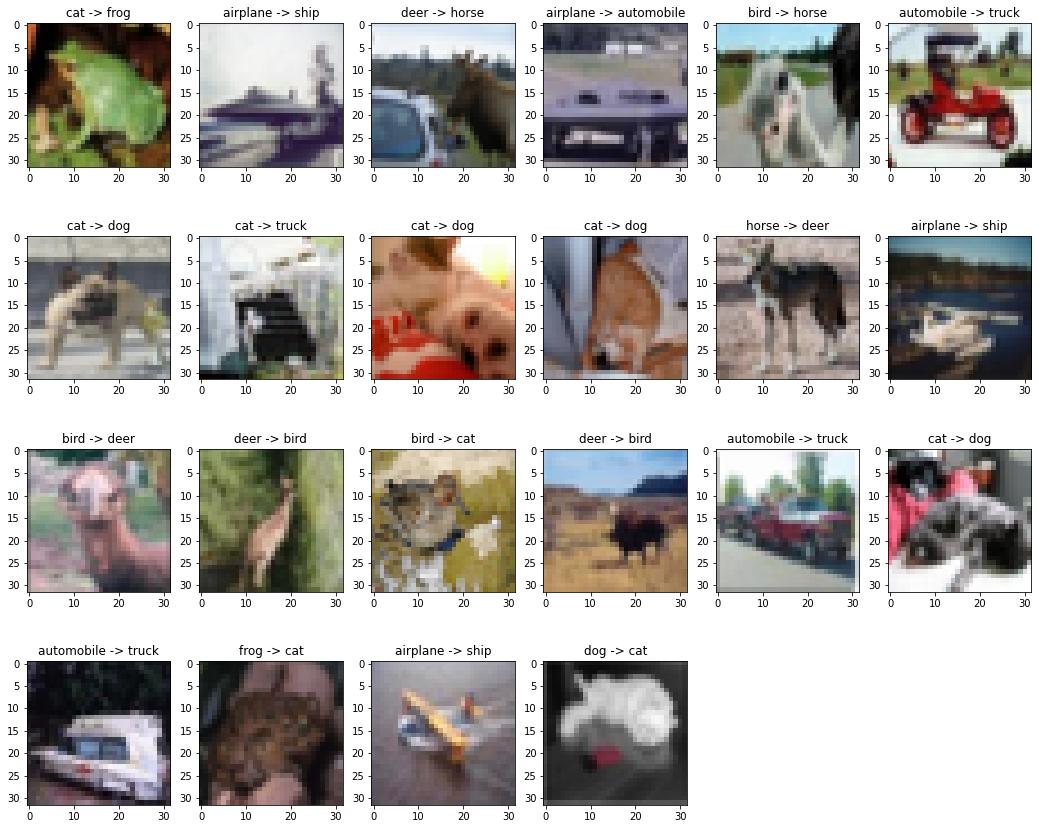

In [130]:
plt.figure(figsize=(18,15))
for idx, i in enumerate(label_numbers):
    plt.subplot(4, 6, idx+1)
    plt.title(f'now : {label[y_test[i][0]]}, change : {real_class_names[idx]}')
    
    plt.imshow(x_test[i])
plt.show()

In [135]:
# 클래스명과 라벨 번호 설정
class_names = list(label.values())
new_labels = [class_names.index(name) for name in real_class_names]

# 라벨 수정 전 정보 추출 및 저장
original_labels = [class_names[y_test[i][0]] for i in label_numbers]

# 라벨 수정
for i, new_label in zip(label_numbers, new_labels):
    y_test[i] = new_label

# 수정된 라벨 정보 저장
modified_labels = [class_names[y_test[i][0]] for i in label_numbers]

- `categorical하게 변경`

In [140]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

- `데이터셋 분할`

In [141]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [142]:
x_train.shape, x_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3))

### 2. 하이퍼파라미터 튜닝

- `하이퍼 파라미터 튜닝`

In [143]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice('batch_size', [16, 32]), **fit_kwargs)

        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(model.metrics_names, eval_scores)}

In [151]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
    x_train, y_train, validation_data=(x_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 14s]
accuracy: 0.5582000017166138

Best accuracy So Far: 0.6513000130653381
Total elapsed time: 00h 03m 57s


In [152]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_46 (Averag (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_47 (Averag (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_32 (Flatten)         (None, 2304)            

In [154]:
model.fit(x_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4967 - accuracy: 0.5026
Epoch 2/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0206 - accuracy: 0.6421
Epoch 3/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8499 - accuracy: 0.7021
Epoch 4/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7237 - accuracy: 0.7467
Epoch 5/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6118 - accuracy: 0.7851


In [155]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.0013 - accuracy: 0.6835


[1.0012595653533936, 0.6834999918937683]

### 회고
## Keep
- 모델에 맞게 구성하려 노력하였다.

## Problem
- 배포할 시간, TFLite 모델 만들기엔 시간이 너무 부족했다.

## Try
- 최대한 모델의 구조를 유지한 채 하이퍼파라미터 튜닝을 시도해보았다.